# Исследование корреляции солнечной активности и биржи

In [1]:
import pandas as pd

In [2]:
#url = 'https://www.spaceweather.gc.ca/solar_flux_data/daily_flux_values/fluxtable.txt'
df = pd.read_csv('fluxtable.txt', delim_whitespace=True, skiprows=[1])

# Объединяем fluxdate и fluxtime в одно поле timestamp
df['timestamp'] = pd.to_datetime(df['fluxdate'].astype(str) + df['fluxtime'].astype(str), format='%Y%m%d%H%M%S')

# Удаляем старые колонки fluxdate и fluxtime
df.drop(columns=['fluxdate', 'fluxtime'], inplace=True)

# Перемещаем колонку timestamp в начало
df = df[['timestamp'] + [col for col in df.columns if col != 'timestamp']]
df.head(3)

,timestamp,fluxjulian,fluxcarrington,fluxobsflux,fluxadjflux,fluxursi
0,2004-10-28 17:00:00,2453307.229,2022.605,132.7,130.9,117.8
1,2004-10-28 20:00:00,2453307.354,2022.610,135.8,134.0,120.6
2,2004-10-29 20:00:00,2453308.354,2022.646,130.6,128.8,115.9


In [3]:
solar=df.set_index('timestamp')[['fluxadjflux']].resample('D').mean().reset_index()
solar.head(3)

,timestamp,fluxadjflux
0,2004-10-28,132.450000
1,2004-10-29,130.550000
2,2004-10-30,139.466667


In [4]:
import yfinance as yf

In [5]:
tickers = '''AAPL, MSFT, AMZN, GOOGL, META, TSLA, JNJ, JPM, V, PG, NVDA, WMT, 
             DIS, BAC, MA, INTC, PFE, XOM, NFLX, ADBE, CRM, KO, PEP, GE'''

# Загружаем данные с конкретной начальной даты
raw_data = yf.download(
    tickers=tickers,
    start="2004-10-28",
    interval="1d",
    progress=True,
    group_by='ticker',
    threads=True ,
)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  24 of 24 completed


In [6]:
raw_data.head(3)

Ticker     TSLA                       META                        ...  \
Price      Open High Low Close Volume Open High Low Close Volume  ...   
Date                                                              ...   
2004-10-28  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...   
2004-10-29  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...   
2004-11-01  NaN  NaN NaN   NaN    NaN  NaN  NaN NaN   NaN    NaN  ...   

Ticker             KO                                                   DIS  \
Price            Open       High        Low      Close    Volume       Open   
Date                                                                          
2004-10-28  10.942138  11.056089  10.849890  10.985548  12326400  19.848974   
2004-10-29  11.096785  11.096785  10.988258  11.031669  16822600  19.872820   
2004-11-01  11.042519  11.064224  10.936707  10.996395  11649200  19.976156   

Ticker                                                
Price            High        Low      Close   Volume  
Date                                                  
2004-10-28  20.031805  19.697942  19.968212  4965129  
2004-10-29  20.079497  19.793329  20.047701  6362899  
2004-11-01  20.206680  19.705886  20.055647  5372428  

[3 rows x 120 columns]

In [7]:
# Извлекаем цены закрытия и преобразуем структуру
close_prices = (
    raw_data
    .xs('Close', level=1, axis=1)      # Выбираем уровень Close
    .sort_index()                       # Сортируем по времени
)
close_prices.head(3)

Ticker,TSLA,META,NFLX,ADBE,CRM,MSFT,INTC,XOM,PG,AMZN,...,WMT,MA,BAC,PFE,PEP,V,JPM,GE,KO,DIS
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-28,NaN,NaN,1.370000,27.733749,5.009520,17.440025,12.849724,24.671703,29.297045,1.7225,...,11.939094,NaN,28.174042,11.836781,28.334293,NaN,22.336191,97.818993,10.985548,19.968212
2004-10-29,NaN,NaN,1.352857,28.003637,5.051784,17.415108,12.843959,24.981312,29.222807,1.7065,...,11.923616,NaN,28.344904,11.935726,28.357178,NaN,22.405857,98.077736,11.031669,20.047701
2004-11-01,NaN,NaN,1.347143,28.158575,5.394868,17.483606,12.947817,24.778297,29.120031,1.7550,...,11.908135,NaN,28.547405,11.873887,28.197027,NaN,22.347805,97.876488,10.996395,20.055647


In [8]:
# Для солнечных данных
solar = df.set_index('timestamp')[['fluxadjflux']].resample('D').mean()

# Для цен акций (ваш текущий код)
close_prices = raw_data.xs('Close', level=1, axis=1).sort_index()

# Объединяем данные в один DataFrame
combined = solar.join(close_prices, how='inner').dropna()


combined.head(5)

,fluxadjflux,TSLA,META,NFLX,ADBE,CRM,MSFT,INTC,XOM,PG,...,WMT,MA,BAC,PFE,PEP,V,JPM,GE,KO,DIS
2012-05-18,134.033333,1.837333,38.084518,9.994286,31.309999,36.192848,23.397007,18.292826,48.813309,44.061722,...,16.045563,36.651825,5.621059,13.038116,47.047939,25.710625,23.570282,70.976349,24.911928,38.746353
2012-05-21,128.333333,1.918000,33.900505,10.248571,32.009998,37.055531,23.780703,18.348951,49.154816,43.971558,...,16.202347,38.139973,5.468923,13.020789,46.951263,26.527771,22.880554,71.613083,25.066689,39.259315
2012-05-22,123.900000,2.053333,30.882032,9.672857,32.009998,37.154976,23.788685,18.264753,49.100899,43.805069,...,16.379690,38.405647,5.589033,12.922582,47.020332,27.023083,23.936255,71.837814,24.959023,39.259315
2012-05-23,119.966667,2.068000,31.878227,10.272857,32.180000,37.443363,23.269112,17.850763,49.154816,43.277885,...,16.598152,38.744717,5.741168,12.760832,46.965076,27.201124,24.112202,71.837814,25.080135,39.100121
2012-05-24,119.766667,2.018667,32.904308,10.038571,31.540001,36.349472,23.237133,17.998116,49.496338,43.402740,...,16.724087,38.999233,5.717148,12.789718,47.524517,27.338079,23.908115,72.099983,25.419928,39.303528


In [10]:
# сохраним промежуточные данные тк у Yahoo Finance серьезные лимиты на IP
to_save = combined.round(4)
to_save.to_csv('combined.csv')
del to_save

In [11]:
# Рассчитываем корреляции с статистической значимостью
from scipy.stats import pearsonr
ticker_columns = [col for col in combined.columns if col != 'fluxadjflux']

corr_list = []
for ticker in ticker_columns:
    r, p_value = pearsonr(combined['fluxadjflux'], combined[ticker])
    corr_list.append({
        'Ticker': ticker,
        'Correlation': r,
        'p-value': p_value,
        'Significant (5%)': p_value < 0.05
    })

corr_df = pd.DataFrame(corr_list).sort_values('Correlation', key=abs, ascending=False)

print("Детализированные результаты корреляции:")
print(corr_df)

Детализированные результаты корреляции:
   Ticker  Correlation        p-value  Significant (5%)
7     XOM     0.703333   0.000000e+00              True
10   NVDA     0.595303  1.111240e-306              True
21     GE     0.481083  2.392176e-185              True
6    INTC    -0.466379  7.710201e-173              True
11   AAPL     0.451224  1.422324e-160              True
14    WMT     0.438762  6.088150e-151              True
5    MSFT     0.416406  1.209072e-134              True
13  GOOGL     0.372227  7.019363e-106              True
22     KO     0.368707  8.972966e-104              True
23    DIS    -0.363118  1.753713e-100              True
8      PG     0.361320   1.944400e-99              True
0    TSLA     0.356891   6.825978e-97              True
20    JPM     0.341780   1.649967e-88              True
1    META     0.308881   8.268463e-72              True
18    PEP     0.302679   6.863085e-69              True
15     MA     0.289234   8.371365e-63              True
19      

# Проверка

Если эффект есть, значит он должен быть устойчивым.
Просто разделим данные на два промежутка. Выберем дату произвольно

In [12]:
# Разделяем данные на две части по дате
split_date = '2019-01-01'

combined_before = combined.loc[:split_date]  # Все данные ДО 2019-01-01
combined_after = combined.loc[split_date:]   # Все данные ПОСЛЕ 2019-01-01 (включительно)

In [13]:
combined_before.head(3)

,fluxadjflux,TSLA,META,NFLX,ADBE,CRM,MSFT,INTC,XOM,PG,...,WMT,MA,BAC,PFE,PEP,V,JPM,GE,KO,DIS
2012-05-18,134.033333,1.837333,38.084518,9.994286,31.309999,36.192848,23.397007,18.292826,48.813309,44.061722,...,16.045563,36.651825,5.621059,13.038116,47.047939,25.710625,23.570282,70.976349,24.911928,38.746353
2012-05-21,128.333333,1.918000,33.900505,10.248571,32.009998,37.055531,23.780703,18.348951,49.154816,43.971558,...,16.202347,38.139973,5.468923,13.020789,46.951263,26.527771,22.880554,71.613083,25.066689,39.259315
2012-05-22,123.900000,2.053333,30.882032,9.672857,32.009998,37.154976,23.788685,18.264753,49.100899,43.805069,...,16.379690,38.405647,5.589033,12.922582,47.020332,27.023083,23.936255,71.837814,24.959023,39.259315


In [14]:
combined_after.head(3)

,fluxadjflux,TSLA,META,NFLX,ADBE,CRM,MSFT,INTC,XOM,PG,...,WMT,MA,BAC,PFE,PEP,V,JPM,GE,KO,DIS
2019-01-02,72.400000,20.674667,135.163681,267.660004,224.570007,134.797104,95.310547,40.518047,51.719868,77.998955,...,28.292696,183.216721,21.551329,31.420736,91.920593,127.274910,82.916222,37.585003,38.957546,106.340645
2019-01-03,70.533333,20.024000,131.238693,271.200012,215.699997,129.675690,91.804260,38.289032,50.925781,77.452080,...,28.147200,174.951035,21.205956,30.541683,91.062630,122.688354,81.737846,37.631702,38.716816,103.764343
2019-01-04,69.566667,21.179333,137.425049,297.570007,226.190002,137.193710,96.074020,40.638538,52.803406,79.032898,...,28.323004,183.236053,22.086660,31.239115,92.929947,127.973877,84.751129,38.425426,39.488815,106.965195


In [15]:

# Создаем функцию для расчета корреляций
def calculate_correlations(df):
    corr_list = []
    for ticker in df.columns.drop('fluxadjflux'):
        r, p_value = pearsonr(df['fluxadjflux'], df[ticker])
        corr_list.append({
            'Ticker': ticker,
            'Correlation': r,
            'p-value': p_value,
            'Significant (5%)': p_value < 0.05
        })
    return pd.DataFrame(corr_list).sort_values('Correlation', key=abs, ascending=False)

# Считаем для первого периода
print("Корреляции ДО 2019-01-01:")
corr_before = calculate_correlations(combined_before)
print(corr_before)

# Считаем для второго периода
print("\nКорреляции ПОСЛЕ 2019-01-01:")
corr_after = calculate_correlations(combined_after)
print(corr_after)

Корреляции ДО 2019-01-01:
   Ticker  Correlation        p-value  Significant (5%)
9    AMZN    -0.708256  1.286142e-253              True
13  GOOGL    -0.704263  1.490080e-249              True
1    META    -0.693574  5.283454e-239              True
20    JPM    -0.690082  1.175255e-235              True
19      V    -0.688774  2.046663e-234              True
5    MSFT    -0.687889  1.405197e-233              True
10   NVDA    -0.687399  4.062648e-233              True
18    PEP    -0.678201  1.282293e-224              True
22     KO    -0.671477  1.340047e-218              True
3    ADBE    -0.667547  3.727956e-215              True
12    JNJ    -0.660193  7.536609e-209              True
2    NFLX    -0.654410  5.151881e-204              True
4     CRM    -0.649794  3.127275e-200              True
15     MA    -0.644770  3.457685e-196              True
11   AAPL    -0.637069  3.892666e-190              True
6    INTC    -0.630538  3.880669e-185              True
16    BAC    -0.615966

**ВЫВОДЫ**: Эффект не повторился в двух разных промежутках времени


# Графики
все же попробуем графически понять почему некоторые тикеры  хорошо коррелируют

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_ticker_correlation(ticker, df=combined):
    """
    Анализирует корреляцию между солнечной активностью и указанным тикером.
    
    Параметры:
    ticker (str): Название тикера (например, 'XOM')
    df (DataFrame): DataFrame с данными (по умолчанию combined)
    """
    # Проверка наличия тикера
    if ticker not in df.columns:
        print(f"Ошибка: Тикер {ticker} отсутствует в данных")
        return
    
    # Создаем копию данных для безопасной обработки
    data = df[['fluxadjflux', ticker]].copy()
    
    # Нормализация данных
    def manual_minmax_scale(series):
        return (series - series.min()) / (series.max() - series.min())
    
    data_norm = pd.DataFrame({
        'fluxadjflux_norm': manual_minmax_scale(data['fluxadjflux']),
        f'{ticker}_norm': manual_minmax_scale(data[ticker])
    }, index=data.index)
    
    # График временных рядов
    plt.figure(figsize=(14, 6))
    plt.title(f'Сравнение нормализованных рядов: Солнечная активность vs {ticker}')
    
    plt.plot(data_norm['fluxadjflux_norm'], 
             label='Solar Flux (norm)', 
             color='orange',
             alpha=0.7)
    
    plt.plot(data_norm[f'{ticker}_norm'], 
             label=f'{ticker} Price (norm)', 
             color='blue',
             alpha=0.5,
             linestyle='--')
    
    plt.legend()
    plt.xlabel('Дата')
    plt.ylabel('Нормализованные значения')
    plt.grid(True)
    plt.show()
    
    # Scatter plot с регрессией
    plt.figure(figsize=(8, 6))
    sns.regplot(x=data['fluxadjflux'], 
                y=data[ticker],
                scatter_kws={'alpha':0.3, 'color':'green'},
                line_kws={'color':'red'})
    
    plt.title(f'Корреляция: Солнечный Flux vs Цена {ticker}')
    plt.xlabel('Solar Flux Adjusted')
    plt.ylabel(f'{ticker} Stock Price')
    plt.grid(True)
    
    # Рассчет корреляции
    r = data['fluxadjflux'].corr(data[ticker])
    plt.annotate(f'Pearson r = {r:.2f}\nN = {len(data):,}', 
                 xy=(0.05, 0.95), 
                 xycoords='axes fraction',
                 fontsize=12,
                 bbox=dict(facecolor='white', alpha=0.8))
    
    plt.show()


Нарисуем лучший случай

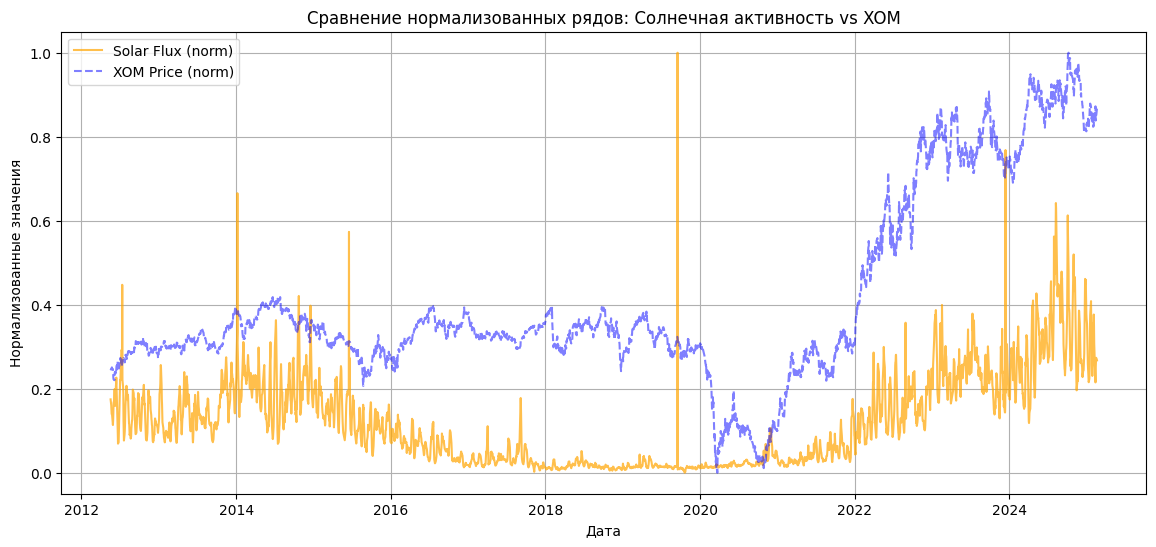

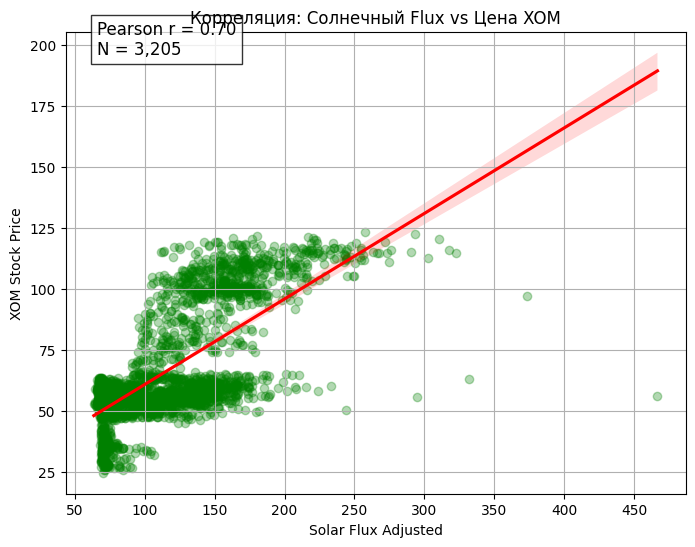

In [17]:

analyze_ticker_correlation('XOM')

Нарисуем худший случай

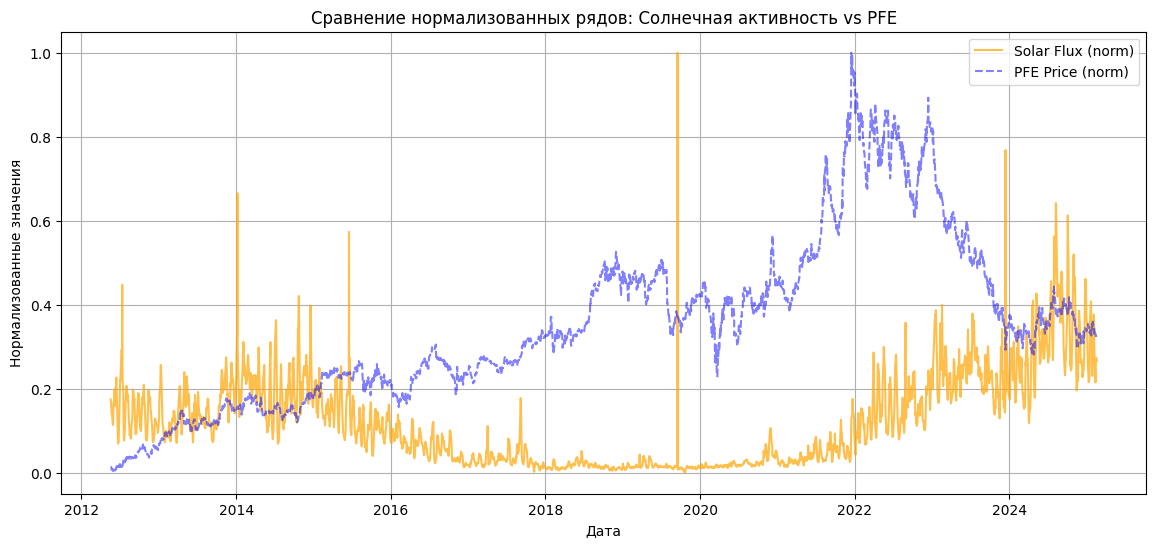

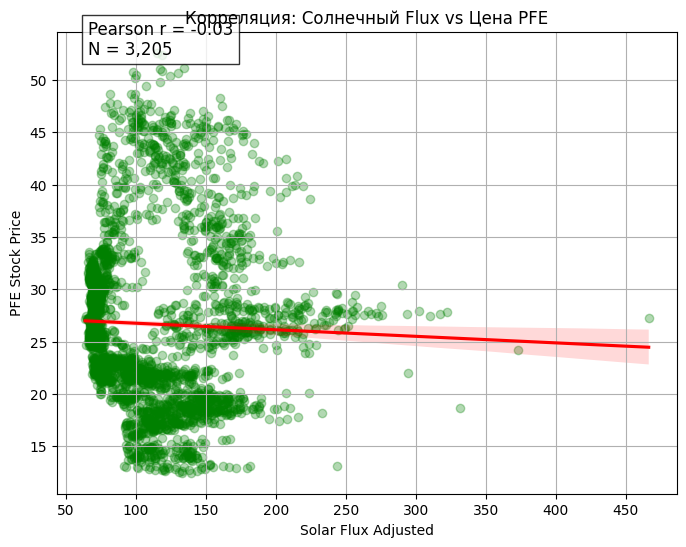

In [18]:
analyze_ticker_correlation('PFE')

# Выводы

- На Солнце есть длинные циклы.
- Иногда эти циклы совпадают с развитием компаний.
- Иногда эта корреляция довольно высокая